**This notebook contains the code for generating the metric (PDR) plots included in the paper**

In [1]:
import os
import sys
sys.path.append('../../')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from matplotlib.lines import Line2D
from statsmodels.stats.multitest import multipletests
import itertools
from sklearn.utils import resample

In [3]:
from facct22.utils import get_db_con

from facct22.analysis_functions import (
    get_all_decisions, groups, schemas, users, dps, dt, pdr, group_order, colors, 
    ttests_operational_metrics, assign_conf_mat_cell, _modify_value_and_time
)

In [4]:
cred_file = '../../conf/credentials.yaml'
engine = get_db_con(cred_file)

#### Parameters Used for generating the plots 

For the first set of plots, we are going to use a set of common sense values for the parameters. For suspicious, we assume that correct classification and with a time penalty

In [5]:
params={
    'fn': -3, 
    'p_loss_trx': 0.5, # prob of losing this transaction
    'cust_worth': 3, # The long term customer worth as a coefficiant of the trx val
    'p_loss_cust': 0.1, # probablity of losing the customer due to the rejection
    'p_return_cust': 1, # probability of the customer creating future worth as we expect
    'suspicious_add_time': 600
}

In [6]:
coeffs = {
    'tp': 0,
    'tn': 1 + (params['cust_worth']) * params['p_return_cust'],
    'fn': params['fn'],
    'fp': (1 - params['p_loss_trx']) + (params['cust_worth'] * (1-params['p_loss_cust']))# assuming the customer worth is on average n times the transaction value
}

coeffs

{'tp': 0, 'tn': 4, 'fn': -3, 'fp': 3.2}

#### Decisions

In [7]:
all_decisions = get_all_decisions(engine, schemas, users, groups)
suspicious_msk = all_decisions['decision'] == 'suspicious'


# Balancing the transaction values
transaction_value_cap = 2000

msk = all_decisions['trx_amnt'] > transaction_value_cap
all_decisions.loc[msk, 'trx_amnt'] = transaction_value_cap

#### PDR vs Time  

In [10]:
def plot_time_vs_op_metric(
    op_metric, time_metric, group_order, colors, markers, 
    title='', ylabel='', confidence=0.9, xlim=[], ylim=[], save_target=None):
    
    merged = op_metric.merge(
        time_metric, on='group', suffixes=('_met', '_dt')
    )
    
    fig, ax = plt.subplots(dpi=200, figsize=(4, 3))
    
    
   
    for i, g in enumerate(group_order):
        msk = merged['group'] == g
        df = merged[msk]
        
        interval = stats.norm.ppf(1-(1-confidence)/2)
        
        ax.errorbar(
            df['mean_dt'],
            df['mean_met'] * 100,
            yerr=df['se_met'] * 100 * interval,
            xerr=df['se_dt'] * interval,
            color=colors[i],
            linewidth=1,
            alpha=0.5
        )
        ax.scatter(
            df['mean_dt'], 
            df['mean_met'] * 100, 
            color=colors[i], 
            label=g, 
            marker=markers[i],
#             linewidths=0.01,
#             edgecolors='k'
            
        )

    ax.legend(frameon=False, labelspacing=0.7, handletextpad=0.2, fontsize=8, ncol=2, bbox_to_anchor=(1.05,1.05), loc='upper right', columnspacing=0.7)
#     ax.legend(frameon=True) , 
    ax.set_ylabel(ylabel)
    ax.set_xlabel('Mean Decision Time (s)')
    ax.set_title(title)
    if xlim:
        ax.set_xlim(xlim)
        
    if ylim:
        ax.set_ylim(ylim)
    sns.despine()
    
    if save_target is not None:
        
        plt.savefig(
            save_target, format='svg', bbox_inches='tight', transparent=True
        )


n_samples not set. Defaulting to the group size
n_samples not set. Defaulting to the group size
n_samples not set. Defaulting to the group size
n_samples not set. Defaulting to the group size
n_samples not set. Defaulting to the group size
n_samples not set. Defaulting to the group size
n_samples not set. Defaulting to the group size


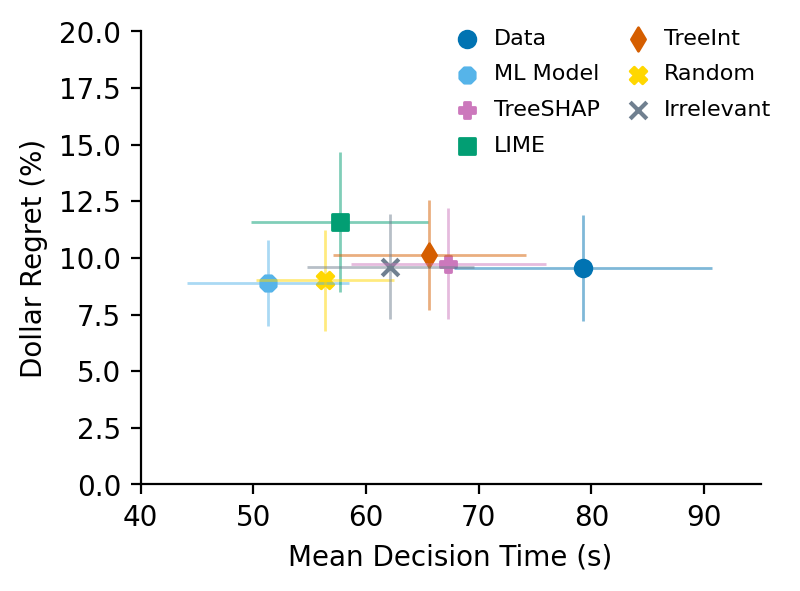

In [11]:
xlim = [40, 95]
ylim = [0., 20]

colors2 = [
    sns.color_palette("colorblind")[0],
    sns.color_palette("colorblind")[9],
    sns.color_palette("colorblind")[4],
    sns.color_palette("colorblind")[3],
    sns.color_palette("colorblind")[2],
    sns.color_palette("coolwarm")[0],
    sns.color_palette("coolwarm")[1],
]

colors3 = [
    sns.color_palette("colorblind")[0],
    sns.color_palette("colorblind")[9],
    sns.color_palette("colorblind")[4],
    sns.color_palette("colorblind")[2],
    sns.color_palette("colorblind")[3],
    'gold',
#     sns.color_palette("colorblind")[8],
    'slategray'
#     sns.color_palette("colorblind")[7],
]

markers = ["o", "8", "P", "s", "d", "X", "x"]
regret = pdr(all_decisions, params, 'correct', ['group'], n_iterations=1000)
time = dt(all_decisions, params, 'correct', ['group'])
plot_time_vs_op_metric(
    regret, time, group_order, 
    colors3,
    markers,
    ylabel='Dollar Regret (%)',
#     title='Percent Dollar Regret vs Decision Time, Suspicious $\longrightarrow$ Correct',
    xlim=xlim,
    ylim=ylim,
#     save_target='results/figures_for_paper/pdr_vs_time_new.pdf'
    save_target='results/figures_for_paper/pdr_vs_time_new.svg'
)

In [10]:
regret

,group,mean,n,se,var
0,Data,0.094953,495,0.013527,0.090577
1,Irrelevant,0.096265,499,0.013652,0.093008
2,LIME,0.116026,499,0.018655,0.173649
3,ML Model,0.088485,499,0.011574,0.066847
4,Random,0.090993,496,0.013798,0.094436
5,TreeInt,0.101479,496,0.014342,0.102019
6,TreeSHAP,0.097454,497,0.015265,0.115805


##### Combining all explainers into one group

In [12]:
def group_explainers(row):
    if row['group'] in {'LIME', 'TreeSHAP', 'TreeInt'}:
        return 'Explainer'
    else:
        return row['group']
    
    
all_decisions['group2'] = all_decisions.apply(lambda x: group_explainers(x), axis=1)

In [13]:
def ttests_operational_metrics(metrics, comparisons, group_col='group'):
    
    results = list()

    for comp in comparisons:
        mean1 = metrics[metrics[group_col] == comp[0]]['mean'].iloc[0]
        mean2 = metrics[metrics[group_col] == comp[1]]['mean'].iloc[0]
        
        var1 = metrics[metrics[group_col] == comp[0]]['var'].iloc[0]
        var2 = metrics[metrics[group_col] == comp[1]]['var'].iloc[0]

        n1 = metrics[metrics[group_col] == comp[0]]['n'].iloc[0]
        n2 = metrics[metrics[group_col] == comp[1]]['n'].iloc[0]
        
        res = stats.ttest_ind_from_stats(
            mean1, np.sqrt(var1), n1,
            mean2, np.sqrt(var2), n2,
        )
        
        
        d = dict()
        d['comparison'] = comp
        d['t-stat'] = res.statistic
        d['p-val'] = res.pvalue
        
        results.append(d)
        
    return pd.DataFrame(results)

n_samples not set. Defaulting to the group size
n_samples not set. Defaulting to the group size
n_samples not set. Defaulting to the group size
n_samples not set. Defaulting to the group size
n_samples not set. Defaulting to the group size


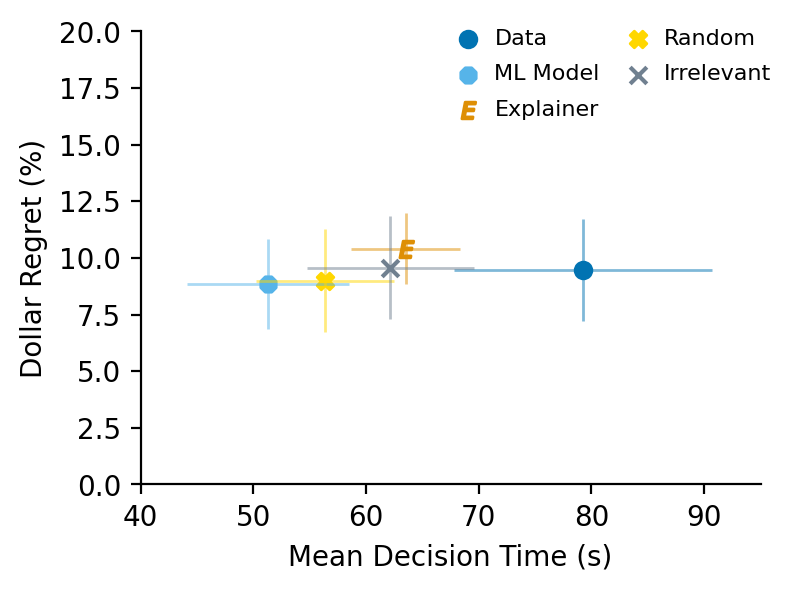

In [14]:
xlim = [40, 95]
ylim = [0, 20]
plot_order = ['Data', 'ML Model', 'Explainer', 'Random', 'Irrelevant']
colors2 = [
    sns.color_palette("colorblind")[0],
    sns.color_palette("colorblind")[9],
    sns.color_palette("colorblind")[1],
#     sns.color_palette("colorblind")[3],
#     sns.color_palette("colorblind")[2],
#     sns.color_palette("colorblind")[8],
    'gold',
    'slategray'
#     sns.color_palette("colorblind")[7],
]
markers = ["o", "8", "$E$", "X", "x"]
regret = pdr(all_decisions, params, 'correct', ['group2'], n_iterations=1000).rename(columns={'group2':'group'})
time = dt(all_decisions, params, 'correct', ['group2']).rename(columns={'group2':'group'})
plot_time_vs_op_metric(
    regret, time, plot_order, colors2, markers,
    ylabel='Dollar Regret (%)',
#     title='PDR vs Decision Time, Suspicious $\longrightarrow$ Correct',
    xlim=xlim,
    ylim=ylim,
#     save_target='results/figures_for_paper/pdr_vs_time_exp_combined_new.pdf'
    save_target='results/figures_for_paper/pdr_vs_time_exp_combined_new.svg'
)

In [15]:
regret

,group,mean,n,se,var
0,Data,0.094646,495,0.013724,0.093227
1,Explainer,0.104137,1492,0.009460,0.133512
2,Irrelevant,0.095781,499,0.013705,0.093724
3,ML Model,0.088536,499,0.012029,0.072209
4,Random,0.089884,496,0.013785,0.094257


#### Significance with the grouped explainer

In [16]:
time = dt(all_decisions, params, 'correct', ['group2']).rename(columns={'group2':'group'})

comparisons = [
    ('Data', 'ML Model'),
    ('ML Model', 'Explainer'),
    ('ML Model', 'Random'),
    ('ML Model', 'Irrelevant'),
    ('Random', 'Explainer'),
    ('Irrelevant', 'Explainer'),
    ('Irrelevant', 'Random')
]
ttests_operational_metrics(time, comparisons)

,comparison,p-val,t-stat
0,"(Data, ML Model)",0.000673,3.410986
1,"(ML Model, Explainer)",0.031305,-2.154707
2,"(ML Model, Random)",0.380179,-0.877957
3,"(ML Model, Irrelevant)",0.084292,-1.728035
4,"(Random, Explainer)",0.194686,-1.297279
5,"(Irrelevant, Explainer)",0.813372,-0.236109
6,"(Irrelevant, Random)",0.321031,0.992837


#### PDR broken down by user 

In [17]:
def plot_time_vs_op_metric_user(
    op_metric, time_metric, group_order, colors, markers,
    title='', ylabel='', confidence=0.9, xlim=[], ylim=[], save_target=None):
    
    merged = op_metric.merge(
        time_metric, on=['group', 'user_name'], suffixes=('_met', '_dt')
    )
    
    fig, axes = plt.subplots(1, 3, dpi=200, figsize=(10, 3), sharey=True, sharex=True)
    
    user_name_mapping = {
        'j': 'A1',
        'n': 'A2',
        't': 'A3'
    }
    
    for j, user in enumerate(['j', 'n', 't']):
        for i, g in enumerate(group_order):
            msk = (merged['group'] == g) & (merged['user_name'] == user)
            
            df = merged[msk]

            interval = stats.norm.ppf(1-(1-confidence)/2)

            ax = axes[j]
            
            ax.errorbar(
                df['mean_dt'],
                df['mean_met'] * 100,
                yerr=df['se_met'] * 100 * interval,
                xerr=df['se_dt'] * interval,
                color=colors[i],
                alpha=0.4
            )
            ax.scatter(df['mean_dt'], df['mean_met'] * 100, color=colors[i], label=g, marker=markers[i])

            if j==0:
                ax.set_ylabel(ylabel)
            ax.set_xlabel('Mean Decision Time (s)')
#             ax.set_title(user.upper())
            ax.set_title(user_name_mapping[user])
            if xlim:
                ax.set_xlim(xlim)

            if ylim:
                ax.set_ylim(ylim)
            sns.despine()
    
    ax.legend(frameon=False, bbox_to_anchor=(0.9, 1))

    if save_target is not None:    
        plt.savefig(
            save_target, dpi='figure', format='pdf', bbox_inches='tight'
        )


In [18]:
regret = pdr(all_decisions, params, 'correct', ['group', 'user_name'], n_iterations=1000)
time = dt(all_decisions, params, 'correct', ['group', 'user_name'])

n_samples not set. Defaulting to the group size
n_samples not set. Defaulting to the group size
n_samples not set. Defaulting to the group size
n_samples not set. Defaulting to the group size
n_samples not set. Defaulting to the group size
n_samples not set. Defaulting to the group size
n_samples not set. Defaulting to the group size
n_samples not set. Defaulting to the group size
n_samples not set. Defaulting to the group size
n_samples not set. Defaulting to the group size
n_samples not set. Defaulting to the group size
n_samples not set. Defaulting to the group size
n_samples not set. Defaulting to the group size
n_samples not set. Defaulting to the group size
n_samples not set. Defaulting to the group size
n_samples not set. Defaulting to the group size
n_samples not set. Defaulting to the group size
n_samples not set. Defaulting to the group size
n_samples not set. Defaulting to the group size
n_samples not set. Defaulting to the group size
n_samples not set. Defaulting to the gro

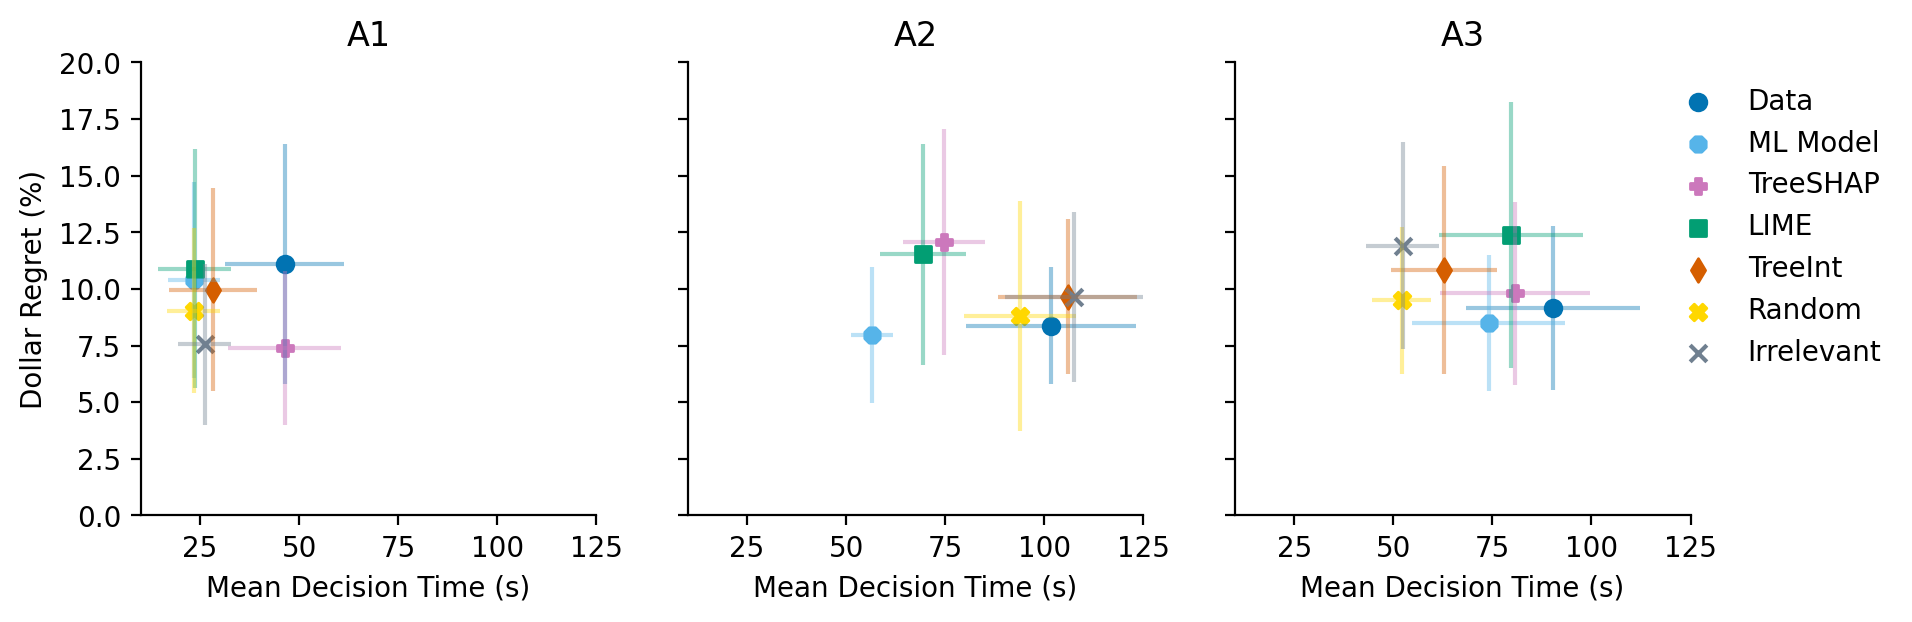

In [22]:
markers = ["o", "8", "P", "s", "d", "X", "x"]

# markers = ["o"] * 7

plot_time_vs_op_metric_user(
    regret, time, group_order, 
    colors3,
    markers,
    ylabel='Dollar Regret (%)',
    xlim=[10, 125],
    ylim=[0, 20],
#     save_target='results/figures_for_paper/pdr_vs_time_users.pdf'

)

#### Param Sweep Results

In [23]:
metrics_param_sweep = pd.read_csv('param_sweep_op_metrics_new.csv')

In [24]:
metrics_param_sweep['group'].replace({'Control-A': 'Data', 'Control-B': 'ML Model'}, inplace=True)

In [25]:
msk = metrics_param_sweep['metric'] == 'dt'
times = metrics_param_sweep[msk]

msk = metrics_param_sweep['metric'] == 'pdr'
regrets = metrics_param_sweep[msk]

0.09472525234308452
0.09599440539268878
0.11467052581591607
0.08924994114236216
0.08902643179996118
0.10055017996572849
0.0963648040107654


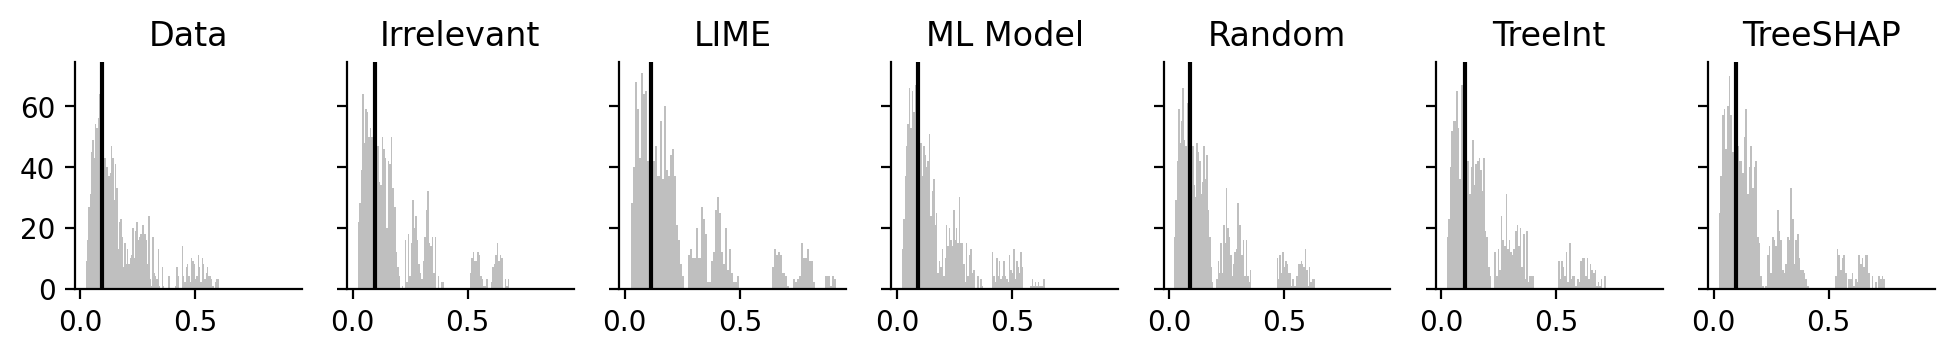

In [26]:
regret = pdr(all_decisions, params, 'correct', ['group'], n_samples=500, n_iterations=1000)

# msk = (metrics_param_sweep['metric'] == 'pdr') & (metrics_param_sweep['suspicious_strategy'] == 'correct') & (metrics_param_sweep['p_return_cust'] == 1)
msk = (regrets['p_return_cust'] == 1)
metrics =  regrets[msk]
grp_obj = metrics.groupby(['metric', 'group'])
fig, axes = plt.subplots(1, 7, figsize=(12, 1.5), sharex=True, sharey=True, dpi=200)
i=0
for g, df in grp_obj:
#     print(g)
    if g[0] == 'pdr':
        df['mean'].hist(ax=axes[i], bins=100, grid=False, color='gray', alpha=0.5)
        axes[i].set_title(g[1])
        
        msk = regret['group'] == g[1]
        val = regret[msk]['mean'].iloc[0]
        
        print(val)
        axes[i].axvline(x=val, color='k')
        sns.despine()
        i = i + 1

save_target = 'results/figures_for_paper/pdr_dist_param_sweep.pdf'
plt.savefig(
    save_target, format='pdf', bbox_inches='tight'
)